Here's an attempt to create a recommendation engine with this dataset. Our Naive assumption is that a person's taste in film does not evolve with time.

In [49]:
%pdb

Automatic pdb calling has been turned ON


In [50]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%pylab inline
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

Populating the interactive namespace from numpy and matplotlib


In [51]:
df = pd.read_csv("../1. Data/movie_metadata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

# Feature Engineering

# Make Column for each Genre 

In [54]:
unique_genre_labels = set()
for genre_flags in df.genres.str.split('|').values:
    unique_genre_labels = unique_genre_labels.union(set(genre_flags))
# If Genres contains, 1 otherwise, 0
for label in unique_genre_labels:
    df['Genre='+label] = df.genres.str.contains(label).astype(int)
df = df.drop('genres', axis=1)



# Make color to 1 if movie is color, otherwise, 0

In [55]:
df.color = df.color.map({'Color': 1, ' Black and White':0})

# Delete Duplicate Movie

In [56]:
if len(df.drop_duplicates(subset=['movie_title',
                                  'title_year',
                                  'movie_imdb_link'])) < len(df):
    print('Duplicate Titles Exist')
    duplicates = df[df.movie_title.map(df.movie_title.value_counts() > 1)]
    duplicates.sort_values('movie_title')[['movie_title', 'title_year']]
    df = df.drop_duplicates(subset=['movie_title', 'title_year', 'movie_imdb_link'])

Duplicate Titles Exist


# Map Language, Country, Content_Rating to their counts <br/> (Like their unique id)

In [59]:
counts = df.language.value_counts()
df.language = df.language.map(counts)

count = df.country.value_counts()
df.country = df.country.map(count)

counts = df.content_rating.value_counts()
df.content_rating = df.content_rating.map(counts)



# Make Column for each keywords 


In [60]:
unique_words = set()
for wordlist in df.plot_keywords.str.split('|').values:
    if wordlist is not np.nan:
        unique_words = unique_words.union(set(wordlist))
plot_wordbag = list(unique_words)
for word in plot_wordbag:
    df['plot_has_' + word.replace(' ', '-')] = df.plot_keywords.str.contains(word).astype(float)
df = df.drop('plot_keywords', axis=1)



# Map Actor, Director name to their counts <br/> (Like their unique id)

In [61]:
df.director_name = df.director_name.map(df.director_name.value_counts())

counts = pd.concat([df.actor_1_name, df.actor_2_name, df.actor_3_name]).value_counts()

first_actors = set(df.actor_1_name.unique())
second_actors = set(df.actor_2_name.unique())
third_actors = set(df.actor_3_name.unique())

df.actor_1_name = df.actor_1_name.map(counts)
df.actor_2_name = df.actor_2_name.map(counts)
df.actor_3_name = df.actor_3_name.map(counts)

df = df.drop(['movie_imdb_link'], axis=1)
# Let's check if anything is left as object
df.select_dtypes(include=['O']).columns

Index(['movie_title'], dtype='object')

In [62]:
df.shape

(4919, 8136)

# Now the data is clean enough. Recommend Movies!


Text(0.5, 1.05, 'Missing values in the data')

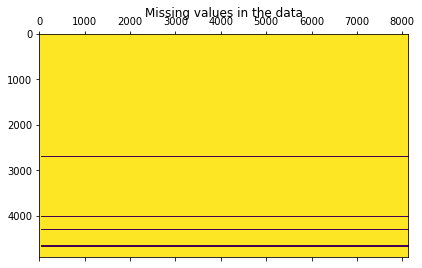

In [63]:
# hold your horses, we still need to fill those missing values.
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
plt.matshow(~df.isnull())
plt.title('Missing values in the data')

(4767, 8136) (4919, 8136)


Text(0.5, 1.05, 'Missing values in the data')

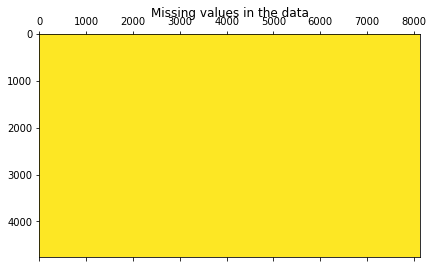

In [64]:
nullcount = df.isnull().sum(axis=1)
# Let's just keep those who have less than a hundred missing values
ndf = df.dropna(thresh=100)
print(ndf.shape, df.shape)
# Let's see those nulls again
plt.matshow(~ndf.isnull())
plt.title('Missing values in the data')

# Fill Missing Value with KNN

In [65]:
# We'll treat fillna as a regression / classification problem here.
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def reg_class_fill(df, column, classifier):
    """Treat missing values as a classification / regresion problem"""
    ndf = df.dropna(subset=[col for col in df.columns if col != column])
    nullmask = ndf[column].isnull()
    train, test  = ndf[~nullmask], ndf[nullmask]
    print(train, test)
    train_x, train_y = train.drop(column, axis=1), train[column]
    classifier.fit(train_x, train_y)
    if len(test) > 0:
        test_x, test_y = test.drop(column, axis=1), test[column]
        values = classifier.predict(test_x)
        test_y = values
        new_x, new_y = pd.concat([train_x, test_x]), pd.concat([train_y, test_y])
        newdf = new_x[column] = new_y
        return newdf
    else:
        return ndf

In [66]:
r, c = KNeighborsRegressor, KNeighborsClassifier  # Regress or classify
title_encoder = LabelEncoder()
title_encoder.fit(ndf.movie_title)
ndf.movie_title = title_encoder.transform(ndf.movie_title)

In [67]:
print(ndf[ndf.columns[:25]].isnull().sum())

color                         13
director_name                 93
num_critic_for_reviews        26
duration                       8
director_facebook_likes       93
actor_3_facebook_likes        17
actor_2_name                  10
actor_1_facebook_likes         7
gross                        751
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  17
facenumber_in_poster          11
num_user_for_reviews           7
language                       8
country                        3
content_rating               223
budget                       445
title_year                    93
actor_2_facebook_likes        10
imdb_score                     0
aspect_ratio                 244
movie_facebook_likes           0
dtype: int64


In [69]:
# Fill Missing value for column below

# director_name, title_year, actor_1_name, actor2_name, actor_3_name
# gross, budget, aspect_ratio, content_rating, num_critic_for_reviews

impute_order = [('director_name', c), ('title_year', c),
                ('actor_1_name', c), ('actor_2_name', c), ('actor_3_name', c),
                ('gross', r), ('budget', r), ('aspect_ratio', r),
                ('content_rating', r), ('num_critic_for_reviews', r)]
for col, classifier in impute_order:
    ndf = reg_class_fill(ndf, col, classifier())

director_name <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
      color  director_name  num_critic_for_reviews  duration  \
0       1.0            7.0                   723.0     178.0   
1       1.0            7.0                   302.0     169.0   
2       1.0            7.0                   602.0     148.0   
3       1.0            8.0                   813.0     164.0   
5       1.0            3.0                   462.0     132.0   
...     ...            ...                     ...       ...   
5026    1.0            2.0                    81.0     110.0   
5027    1.0            1.0                    64.0      90.0   
5033    1.0            1.0                   143.0      77.0   
5035    1.0           13.0                    56.0      81.0   
5042    1.0            3.0                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes  actor_2_name  \
0                         0.0                   855.0           6.0   
1         

title_year Done
actor_1_name <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
      color  director_name  num_critic_for_reviews  duration  \
0       1.0            7.0                   723.0     178.0   
1       1.0            7.0                   302.0     169.0   
2       1.0            7.0                   602.0     148.0   
3       1.0            8.0                   813.0     164.0   
5       1.0            3.0                   462.0     132.0   
...     ...            ...                     ...       ...   
5026    1.0            2.0                    81.0     110.0   
5027    1.0            1.0                    64.0      90.0   
5033    1.0            1.0                   143.0      77.0   
5035    1.0           13.0                    56.0      81.0   
5042    1.0            3.0                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes  actor_2_name  \
0                         0.0                   855.0           6.

actor_2_name Done
actor_3_name <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
      color  director_name  num_critic_for_reviews  duration  \
0       1.0            7.0                   723.0     178.0   
1       1.0            7.0                   302.0     169.0   
2       1.0            7.0                   602.0     148.0   
3       1.0            8.0                   813.0     164.0   
5       1.0            3.0                   462.0     132.0   
...     ...            ...                     ...       ...   
5026    1.0            2.0                    81.0     110.0   
5027    1.0            1.0                    64.0      90.0   
5033    1.0            1.0                   143.0      77.0   
5035    1.0           13.0                    56.0      81.0   
5042    1.0            3.0                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes  actor_2_name  \
0                         0.0                   855.0           

gross Done
budget <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
      color  director_name  num_critic_for_reviews  duration  \
0       1.0            7.0                   723.0     178.0   
1       1.0            7.0                   302.0     169.0   
2       1.0            7.0                   602.0     148.0   
3       1.0            8.0                   813.0     164.0   
5       1.0            3.0                   462.0     132.0   
...     ...            ...                     ...       ...   
5026    1.0            2.0                    81.0     110.0   
5027    1.0            1.0                    64.0      90.0   
5033    1.0            1.0                   143.0      77.0   
5035    1.0           13.0                    56.0      81.0   
5042    1.0            3.0                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes  actor_2_name  \
0                         0.0                   855.0           6.0   
1          

aspect_ratio Done
content_rating <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
      color  director_name  num_critic_for_reviews  duration  \
0       1.0            7.0                   723.0     178.0   
1       1.0            7.0                   302.0     169.0   
2       1.0            7.0                   602.0     148.0   
3       1.0            8.0                   813.0     164.0   
5       1.0            3.0                   462.0     132.0   
...     ...            ...                     ...       ...   
5026    1.0            2.0                    81.0     110.0   
5027    1.0            1.0                    64.0      90.0   
5033    1.0            1.0                   143.0      77.0   
5035    1.0           13.0                    56.0      81.0   
5042    1.0            3.0                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes  actor_2_name  \
0                         0.0                   855.0           6.0

num_critic_for_reviews Done


In [70]:
# Again we check for what else needs to be imputed.
ndf[ndf.columns[:25]].isnull().sum()

color                        0
director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
aspect_ratio                 0
movie_facebook_likes         0
dtype: int64

In [71]:
# Did we get everything?
ndf.isnull().sum().sum()

0

In [72]:
# Now we redo the movie title transformation for our searches.
titles = title_encoder.inverse_transform(ndf.movie_title)

# And we are ready to recommend Movie !
We build a simple KD tree recommender.

In [73]:
# Give us 5 movies that you liked
def get_movies(names):
    movies = []
    for name in names:
        found = [i for i in titles if name.lower() in i.lower()]
        if len(found) > 0:
            movies.append(found[0])
            print(name, ': ', found, 'added', movies[-1], 'to movies')
        else:
            print(name, ': ', found)
    print('-'*10)
    print(movies)
    moviecodes = title_encoder.transform(movies)
    return moviecodes, movies
names = ['fight club', 'gump', # This one is Forrest Gump
                 'usual suspects', 'silence of the lambs']
moviecodes, movies = get_movies(names)

fight club :  ['Fight Club\xa0'] added Fight Club  to movies
gump :  ['Forrest Gump\xa0'] added Forrest Gump  to movies
usual suspects :  ['The Usual Suspects\xa0'] added The Usual Suspects  to movies
silence of the lambs :  ['The Silence of the Lambs\xa0'] added The Silence of the Lambs  to movies
----------
['Fight Club\xa0', 'Forrest Gump\xa0', 'The Usual Suspects\xa0', 'The Silence of the Lambs\xa0']


# Standardize Dataset (Value 0 to 1)

In [74]:
data = ndf.drop('movie_title', axis=1)
data = MinMaxScaler().fit_transform(data)

In [75]:
# We assume KNN's assumptions as valid and proceede to compute a distance_matrix
from sklearn.neighbors import KDTree
from collections import Counter

In [76]:
movies

['Fight Club\xa0',
 'Forrest Gump\xa0',
 'The Usual Suspects\xa0',
 'The Silence of the Lambs\xa0']

In [77]:
titles

array(['Avatar\xa0', "Pirates of the Caribbean: At World's End\xa0",
       'Spectre\xa0', ..., 'Primer\xa0', 'El Mariachi\xa0',
       'My Date with Drew\xa0'], dtype=object)

# KDTree for fast generalized N-point problems


In [78]:
tree = KDTree(data, leaf_size=2)

In [79]:
def recommend(movies, tree, titles, data):
    """
    It is assumed that the movies are in order of decreasing like-able-ness
    Recommend movies on the basis of the KDTree generated.
    Return them in order of increasing distance form knowns.
    """
    titles = list(titles)
    length, recommendations = len(movies) + 1,[]
    
    for i, movie in enumerate(movies):
        weight = length - i
        dist, index = tree.query([data[titles.index(movie)]], k=3)
        for d, m in zip(dist[0], index[0]):
            recommendations.append((d*weight, titles[m]))
    recommendations.sort()
    # Stuff is reorganized by frequency.
    rec = [i[1].strip() for i in recommendations if i[1] not in movies]
    rec = [i[1] for i in sorted([(v, k) for k, v in Counter(rec).items()],
                                reverse=True)]
    return rec

In [80]:

rec = recommend(movies, tree, titles, data)

print('Rank | Movie')
print('-----|------')
fmt = '{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))

Rank | Movie
-----|------
1.   | Black or White
2.   | Untraceable
3.   | The Young Messiah
4.   | The Second Best Exotic Marigold Hotel
5.   | Suspect Zero
6.   | Blood Ties
7.   | 15 Minutes


In [82]:
names = ['harry potter', 'lord of the ring'] # dedicated to A.S.
moviecodes, movies = get_movies(names)
rec = recommend(movies, tree, titles, data)
print('-'*50)
print('Recommending on the basis of the above movies')
print('-'*50)
print()
print('+-----|------')
print('|Rank | Movie')
print('+-----|------')
fmt = '|{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))
print('+-----|------')

harry potter :  ['Harry Potter and the Half-Blood Prince\xa0', 'Harry Potter and the Order of the Phoenix\xa0', 'Harry Potter and the Goblet of Fire\xa0', 'Harry Potter and the Prisoner of Azkaban\xa0', "Harry Potter and the Sorcerer's Stone\xa0", 'Harry Potter and the Chamber of Secrets\xa0'] added Harry Potter and the Half-Blood Prince  to movies
lord of the ring :  ['The Lord of the Rings: The Fellowship of the Ring\xa0', 'The Lord of the Rings: The Return of the King\xa0', 'The Lord of the Rings: The Two Towers\xa0'] added The Lord of the Rings: The Fellowship of the Ring  to movies
----------
['Harry Potter and the Half-Blood Prince\xa0', 'The Lord of the Rings: The Fellowship of the Ring\xa0']
--------------------------------------------------
Recommending on the basis of the above movies
--------------------------------------------------

+-----|------
|Rank | Movie
+-----|------
|1.   | The Lord of the Rings: The Two Towers
|2.   | The Hobbit: The Battle of the Five Armies
|3. 

In [86]:
names = ['star wars', 'back to the future'] # dedicated to A.S.
moviecodes, movies = get_movies(names)
rec = recommend(movies, tree, titles, data)
print('-'*50)
print('Recommending on the basis of the above movies')
print('-'*50)
print()
print('+-----|------')
print('|Rank | Movie')
print('+-----|------')
fmt = '|{}.   | {}'
for index, movie in enumerate(rec[:9]):
    print(fmt.format(index + 1, movie))
print('+-----|------')

star wars :  ['Star Wars: Episode III - Revenge of the Sith\xa0', 'Star Wars: Episode II - Attack of the Clones\xa0', 'Star Wars: Episode I - The Phantom Menace\xa0', 'Star Wars: Episode VI - Return of the Jedi\xa0', 'Star Wars: Episode V - The Empire Strikes Back\xa0', 'Star Wars: Episode IV - A New Hope\xa0'] added Star Wars: Episode III - Revenge of the Sith  to movies
back to the future :  ['Back to the Future Part II\xa0', 'Back to the Future Part III\xa0', 'Back to the Future\xa0'] added Back to the Future Part II  to movies
----------
['Star Wars: Episode III - Revenge of the Sith\xa0', 'Back to the Future Part II\xa0']
--------------------------------------------------
Recommending on the basis of the above movies
--------------------------------------------------

+-----|------
|Rank | Movie
+-----|------
|1.   | The Amazing Spider-Man
|2.   | Multiplicity
|3.   | Baggage Claim
|4.   | Avatar
+-----|------
